# Exercício: RAGAs

Elton Cardoso do Nascimento, 233840

Enunciado:

> - Implementar o RAGAS com o LLaMA-3 70B para avaliar a qualidade das 50 anotações do IIRC usadas no exercício passado.
> - O RAGAS considera context, question, answer; keys que estão disponíveis no conjunto de teste do IIRC.
> - Opcional:
>   - Avaliar as respostas do exercício da aula 9_10
>   - Usar multi agents

Começamos pela importação de bibliotecas que serão utilizadas neste trabalho:

In [88]:
import os #Operações com o SO (arquivos)
import json #Leitura/escrita de arquivos JSON
import time #Sleep
import threading #Multithreading
import abc #Classes abstratas
from typing import Optional, Dict, List, Tuple, Any #Type hints

import tqdm #Barra de progresso
import groq #API para o Llama 3 70B
import sentence_transformers #Comparação entre sentenças
import numpy as np #Operações com arrays
import matplotlib.pyplot as plt #Plots

## Preparação dos dados

Carregamos os dados do dataset IIRC:

In [59]:
if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.isfile("data\\context_articles.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz
    !move context_articles.tar.gz data
    !tar -xf data/context_articles.tar.gz
    !move context_articles.json data

if not os.path.isfile("data\\iirc_test.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
    !move iirc_test.json data

In [60]:
file = open("data\\context_articles.json", "r")
articles = json.load(file)
file.close()

In [61]:
file = open("data\\iirc_test.json", "r")
test_data = json.load(file)
file.close()

E extraímos as 50 primeiras questões, junto das respostas e contextos:

In [62]:
n_question = 50

In [64]:
dataset = []

for i in range(len(test_data)):
    item = test_data[i]

    main_passage_name = item["title"]

    #Get the questions
    for q in item["questions"]:
        data = {}
        
        #Get and format the answer
        if q["answer"]["type"] == "span":
            data["answer"] = q["answer"]["answer_spans"][0]["text"]
        elif q["answer"]["type"] == "value":
            data["answer"] = q["answer"]["answer_value"]+" "+q["answer"]["answer_unit"]
        elif  q["answer"]["type"] == "none":
            continue
        elif q["answer"]["type"] == "binary":
            data["answer"] = q["answer"]["answer_value"]
        else:
            raise ValueError
        
        data["question"] = q["question"]

        context = ""
        for context_item in q["context"]:
            passage = context_item["passage"]
            if passage == "main":
                passage = main_passage_name

            context += f"{passage}: {context_item['text']}"
            context += "\n"

        data["context"] = context
        data["context_sentence_count"] = str(len(q["context"]))

        dataset.append(data)

        if len(dataset) == n_question:
            break
    if len(dataset) == n_question:
            break


Cada entrada do dataset tem então a pergunta ("question"), respostas ("answer"), contexto para responder ("context") e quantidade de sentenças no contexto ("context_sentence_count"):

In [164]:
dataset[0]

{'answer': 'sky and thunder god',
 'question': 'What is Zeus know for in Greek mythology?',
 'context': 'Palici: he Palici the sons of Zeus\nPalici: in Greek mythology\nZeus: Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion\n',
 'context_sentence_count': '3'}

In [65]:
del test_data, articles

## Implementação do RAGAs

Para realizar a implementação do RAGAs, começamos implementando uma interface para realizar inferências com a API do Groq e criar ferramentas (estágios durante a avaliação):

In [ ]:
class GroqInterface:
    '''
    Interface for using the Groq API

    Implements a rate limit control for multi-threading use. 
    '''

    _client :groq.Groq = None 

    LLAMA3_70B = "llama3-70b-8192"

    inference_lock = threading.Lock()
    time_waiter_lock = threading.Lock()
    SINGLE_THREAD = True

    def __init__(self, model:Optional[str]=None, api_key:Optional[str]=None, json_mode:bool=False, system_message:Optional[str]=None, n_retry:int=5):
        '''
        GroqInterface constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
            json_mode (bool): if the model need to output in JSON. Default is False.
            system_message (str): the system message to send to the model, if needed. Default is None.
            n_retyr (int): number of times to retry if the model fails (not considering RateLimitError). Default is 5.
        '''
        
        if GroqInterface._client is None:

            if api_key is None:
                api_key = os.environ.get("GROQ_API_KEY")

            if api_key is None:
                raise RuntimeError("API key is not in the environment variables ('GROQ_API_KEY' variable is not set).")

            GroqInterface._client = groq.Groq(api_key=api_key)

        if model is None:
            model = GroqInterface.LLAMA3_70B
        self._model = model

        self._system_message = system_message


        if json_mode:
            self._response_format = {"type": "json_object"}
        else:
            self._response_format = None
        self._json_mode = json_mode

        self._n_retry = n_retry

    def __call__(self, prompt:str) -> str:
        '''
        Generates the model response

        Args:
            prompt (str): prompt to send to the model.

        Returns:
            str: model response. 
        '''
        done = False
        retry_count = 0
        while not done:
            try:
                if not GroqInterface.SINGLE_THREAD:
                    GroqInterface.inference_lock.acquire()
                    GroqInterface.inference_lock.release()

                messages = []
                if self._system_message is not None:
                    messages.append({"role":"system", "content":self._system_message})
                
                messages.append({"role":"user", "content":prompt})

                chat_completion = GroqInterface._client.chat.completions.create(
                        messages=messages,
                        model=self._model,
                        response_format=self._response_format
                    )
                
                done = True
            except groq.RateLimitError as exception: #Wait
                print("ERROR")
                print(exception)
                
                GroqInterface.error = exception
                if not GroqInterface.SINGLE_THREAD:
                    if not GroqInterface.time_waiter_lock.locked():
                        GroqInterface.time_waiter_lock.acquire()
                        GroqInterface.inference_lock.acquire()
                        time.sleep(2)
                        GroqInterface.time_waiter_lock.release()
                        GroqInterface.inference_lock.release()
                else:
                    time.sleep(2)

            except KeyboardInterrupt as e: #Stop the code
                raise e
            except Exception as e: #Retry
                print("ERROR")
                print(e)
                retry_count += 1
                if retry_count >= self._n_retry:
                    raise e

        return chat_completion.choices[0].message.content

In [ ]:
class Tool(abc.ABC):
    '''
    Base class for creating LLM agent tools.
    '''

    @abc.abstractmethod
    def __call__(self, query:Dict[str, str], context:str) -> Dict[str, str]:
        '''
        Execute the tool.

        Args:
            query (str): query for the tool execution.
            context (str): agent context in the tool execution moment.

        Returns:
            Dict[str, str]: tool results.
        '''
        ...

### Answer Relevance

A relevância da resposta é definida como o alinhamento médio entre perguntas geradas a partir da resposta em relação a pergunta original.

Começamos com um gerador de questões a partir da resposta:

In [ ]:
class QuestionGenerator(Tool, GroqInterface):
    '''
    Generates questions from a given answer
    '''

    _system_message = '''You are a question generator that outputs in JSON. 
The JSON object must use the schema: {'questions':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Generate questions for the given answer:

Answer: {answer}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        QuestionGenerator constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, QuestionGenerator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, List[str]]:
        '''
        Generates questions from a given answer

        Args:
            query (Dict[str, str]): query, must contain a key "answer" with the answer to generate questions.
            context (str, optional): not used. Defaults to None.

        Returns:
            Dict[str, List[str]]: result that contains key "questions" with the questions.
        '''
        answer = query["answer"]
        
        prompt = QuestionGenerator._base_prompt.format(answer=answer)


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

Testando o gerador, podemos observar um primeiro problema do dataset: as respostas contém poucas informações para refazer a pergunta:

In [171]:
question_generator = QuestionGenerator()
questions_0 = question_generator(dataset[0])
questions_1 = question_generator(dataset[1])

In [180]:
print(dataset[0]["question"]+": "+dataset[0]["answer"])
print("----------")
questions_0

What is Zeus know for in Greek mythology?: sky and thunder god
----------


{'questions': ['Who was Zeus in Greek mythology?',
  'What was the title of the Norse god Odin in Viking mythology?',
  'Who was the ruler of Mount Olympus in Greek mythology?',
  'Who controlled the weather in Greek mythology?',
  'What was the name of the principal god of the Norse pantheon?']}

In [179]:
print(dataset[1]["question"]+": "+dataset[1]["answer"])
print("----------")
questions_1

How long had the First World War been over when Messe was named aide-de-camp?: 5 years
----------


{'questions': ['What is the typical tenure of a US president?',
  'How many years are in a standard Olympic cycle?',
  'What is the typical age of a child when they start kindergarten?',
  "What is the duration of a standard bachelor's degree in the US?",
  'How many years are in a standard presidential term in France?']}

Definimos também um comparador de questões utilizando similaridade de cosseno e testamos seu funcionamento:

In [ ]:
class QuestionComparator(Tool):
    '''
    Comparates questions

    '''

    def __init__(self, embedder_model:str="all-MiniLM-L6-v2") -> None:
        '''
        QuestionComparator constructor.

        Args:
            embedder_model (str, optional): model to generate embeddings. Defaults to "all-MiniLM-L6-v2".
        '''
        self._embedder = sentence_transformers.SentenceTransformer(embedder_model)

    def __call__(self, query: Dict[str, str], context: Optional[str]=None) -> Dict[str, str]:
        '''
        Calculates the similarity between one question and a list of questions.

        Args:
            query (Dict[str, str]): must contain keys "query_question" with 
                question to compare with list of questions in "questions" key. 
            context (Optional[str], optional): not used. Defaults to None.

        Returns:
            Dict[str, str]: result, have a single key "score" with the similarity score.
        '''
        query_question = query["query_question"]
        questions = query["questions"]

        q_embedding = self._embedder.encode(query_question, convert_to_tensor=True)
        qi_embeddings = self._embedder.encode(questions, convert_to_tensor=True)
            
        cosine_scores = sentence_transformers.util.cos_sim(q_embedding, qi_embeddings)

        score = cosine_scores.sum().item()
        score /= len(qi_embeddings)

        result = {"score":str(score)}

        return result


In [178]:
question_comparator = QuestionComparator()

comparator_query = {"query_question":dataset[0]["question"], "questions":questions_0["questions"]}
comparator_result = question_comparator(comparator_query)

comparator_result

{'score': '0.5827430248260498'}

E criamos a classe principal:

In [ ]:
class AnswerRelevanceEvaluator(Tool):
    '''
    Evaluates the relevance of a answer.
    '''
    def __init__(self, question_generator:QuestionGenerator=None, question_comparator:QuestionComparator=None) -> None:
        '''
        AnswerRelevanceEvaluator constructor

        Args:
            question_generator (QuestionGenerator, optional): generator to use, if None creates a new with default arguments. Defaults to None.
            question_comparator (QuestionComparator, optional): comparator to use, if None creates a new with default arguments. Defaults to None.
        '''


        if question_generator is None:
            question_generator = QuestionGenerator()
        if question_comparator is None:
            question_comparator = QuestionComparator()

        self._question_generator = question_generator
        self._question_comparator = question_comparator
    
    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        '''
        Evaluates the relevance of a answer.

        Args:
            query (Dict[str, str]): must contain key "answer" with answer to evaluate.
            context (str, optional): not used. Defaults to None.

        Raises:
            ValueError: if query does not contains "answer" key

        Returns:
            Dict[str, str]: result with key "score" with the score.
        '''
        
        if "answer" not in query:
            raise ValueError("Query must have the answer to evaluate (query not have key 'answer').")

        generator_result = self._question_generator(query)

        comparator_query = {"query_question":query["question"], "questions":generator_result["questions"]}
        comparator_result = self._question_comparator(comparator_query)

        return comparator_result

In [ ]:
answer_relevance_evaluator = AnswerRelevanceEvaluator()

In [181]:
answer_relevance_evaluator(dataset[0])

{'score': '0.6399625142415365'}

### Faithfulness

Para avaliar a fidelidade, a pontuação é definida como a proporção de declarações geradas a partir da resposta que estão contidas no contexto.

Começamos criando um gerador de declarações:

In [ ]:
class StatementGenerator(Tool, GroqInterface):
    '''
    Generates statements from a given answer and question.
    '''

    _system_message = '''You are a statement generator that outputs in JSON. 
The JSON object must use the schema: {'statements':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Given a question and answer, create one or more statements from each sentence in the given answer:

Question: {question}
Answer: {answer}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        StatementGenerator constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, StatementGenerator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        '''
        Generates statements based in a given answer.

        Args:
            query (Dict[str, str]): must contains keys "question" with the question and "answer" with the answer.
            context (str, optional): not used. Defaults to None.

        Returns:
            Dict[str, str]: has key 'statements' with a list of generated statements.
        '''
        question = query["question"]
        answer = query["answer"]
        
        prompt = StatementGenerator._base_prompt.format(question=question, answer=answer)


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [182]:
statement_generator = StatementGenerator()
generator_result = statement_generator(dataset[0])

generator_result

{'statements': ['Zeus is known for being the sky god in Greek mythology.',
  'Zeus is known for being the thunder god in Greek mythology.']}

E definimos um verificador a partir do contexto:

In [ ]:
class StatementContextVerificator(Tool, GroqInterface):
    '''
    Verifies if a list of statements is supported by a given context.
    '''

    _system_message = '''You are a statement analist that outputs in JSON. 
The JSON object must use the schema: 
{'analysis':[{'explanation':'str', 'verdict':'bool'}, {'explanation':'str', 'verdict':'bool'}, ...  ]}.

The analysis list must be of same size of the input.

Please use a valid JSON format.'''

    _base_prompt = '''Context: 
{context}

Consider the given context and following statements, then determine whether they are supported by 
the information present in the context. Provide a brief explanation for each statement before arriving at the verdict (true/false). 
Provide a final verdict for each statement in order at the end in the given format. Do not deviate from the specified format.

{statements}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        StatementContextVerificator constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, StatementContextVerificator._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        '''
        Verifies if a list of statements is supported by a given context.

        Args:
            query (Dict[str, str]): must contain a key "statements" with list of statements and a key "rag_context" with the context.
            context (str, optional): main LLM context, not used. Defaults to None.

        Returns:
            Dict[str, str]: result with key 'analysis', a list of objects with keys 'explanation' and 'verdict'.
        '''

        statements = ""
        
        for statement in query["statements"]:
            statements += "Statement: "+statement+"\n"
        
        prompt = StatementContextVerificator._base_prompt.format(statements=statements, context=query["rag_context"])


        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [ ]:
statement_context_verificator = StatementContextVerificator()

In [ ]:
query = {"statements": generator_result["statements"], "rag_context":dataset[0]["context"]}
verificator_result = statement_context_verificator(query)

In [ ]:
verificator_result

{'analysis': [{'explanation': 'The context states that Zeus is the sky and thunder god in ancient Greek religion, which aligns with the statement that Zeus is known as the sky god in Greek mythology.',
   'verdict': True},
  {'explanation': 'The context states that Zeus is the sky and thunder god in ancient Greek religion, which aligns with the statement that Zeus is known as the thunder god in Greek mythology.',
   'verdict': True}]}

E a classe principal que calculará a pontuação:

In [ ]:
class FaithfulnessEvaluator(Tool):
    '''
    Evaluates the faithfulness of a answer.
    '''

    def __init__(self, statement_generator:StatementGenerator=None, statement_context_verificator:StatementContextVerificator=None) -> None:
        '''
        FaithfulnessEvaluator constructor.

        Args:
            statement_generator (StatementGenerator, optional): generator to use, if None creates a new with default arguments. Defaults to None.
            statement_context_verificator (StatementContextVerificator, optional): context verificator to use, if None creates a new with default arguments. Defaults to None.
        '''
        super().__init__()

        if statement_generator is None:
            statement_generator = StatementGenerator()
        if statement_context_verificator is None:
            statement_context_verificator = StatementContextVerificator()

        self._statement_generator = statement_generator
        self._statement_context_verificator = statement_context_verificator

    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        '''
        Evaluates the faithfulness of a answer.

        Args:
            query (Dict[str, str]): must contain keys "question", "answer" and "context".
            context (str, optional): main agent context, not used. Defaults to None.

        Returns:
            Dict[str, str]: result with a single "score" key.
        '''

        generator_result = self._statement_generator(query)

        verificator_query = {"statements": generator_result["statements"], "rag_context":query["context"]}
        verificator_result = self._statement_context_verificator(verificator_query)

        supported = 0
        total = len(generator_result["statements"])

        for analisy in verificator_result["analysis"]:
            supported += analisy["verdict"]

        score = supported/total

        return {"score":str(score)}


In [ ]:
faithfulness_evaluator = FaithfulnessEvaluator()

In [ ]:
faithfulness_evaluator(dataset[0])

{'score': '1.0'}

### Context Relevance

Para avaliar a relevância do contexto, sentenças úteis para responder a questão são extraídas do contexto, e é avaliado a proporção de sentenças úteis extraídas em relação a quantidade total de sentenças no contexto.

Primeiro definimos um extrator de sentenças. Observe que o prompt foi levemente modificado em relação ao artigo para considerar que a resposta estará em formato JSON, não necessitando retornar algo especial caso não existam sentenças úteis.

In [67]:
class SentenceExtractor(Tool, GroqInterface):
    '''
    Extracts relevant sentences for a question from a given context
    '''

    _system_message = '''You are a sentence extractor that outputs in JSON. 
The JSON object must use the schema: {'sentences':['str', 'str', ...]}

Please use a valid JSON format.'''

    _base_prompt = '''Context: 
{context}

Please extract relevant sentences from the provided context that can potentially help answer the following question. 
If no relevant sentences are found, or if you believe the question cannot be answered from the given context, return a object with an empty 'sentences' list.
While extract ing candidate sentences you’re not allowed to make any changes to sentences from given context.

Question: {question}
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        SentenceExtractor constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, SentenceExtractor._system_message)

    def __call__(self, query:Dict[str, str], context:str=None) -> Dict[str, str]:
        '''
        Extracts relevant sentences for a question from a given context.

        Args:
            query (Dict[str, str]): must contain keys "question" with the question that the context answers and "rag_context" with the context.
            context (str, optional): main LLM context, not used. Defaults to None.

        Returns:
            Dict[str, str]: _description_
        '''
        question = query["question"]
        rag_context = query["rag_context"]
        
        prompt = SentenceExtractor._base_prompt.format(question=question, context=rag_context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [68]:
sentence_extractor = SentenceExtractor()

In [69]:
extractor_query = {"question": dataset[0]["question"], "rag_context":dataset[0]["context"]}
extractor_result = sentence_extractor(extractor_query)

In [70]:
extractor_result

{'sentences': ['Zeus: Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion']}

E calculamos o score de relevância:

In [76]:
class ContextRelevanceEvaluator(Tool):
    '''
    Evaluates the relevance of a context to answer a question.
    '''
    
    def __init__(self, sentence_extractor:SentenceExtractor=None) -> None:
        '''
        ContextRelevanceEvaluator constructor.

        Args:
            sentence_extractor (SentenceExtractor, optional): extractor to use, if None creates a new with default arguments. Defaults to None.
        '''
        
        super().__init__()

        if sentence_extractor is None:
            sentence_extractor = SentenceExtractor()

        self._sentence_extractor = sentence_extractor

    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        '''
        Evaluates the relevance of a context to answer a question.

        Args:
            query (Dict[str, str]): must contain keys:
                - "question" with the question.
                - "context" with the context used to answer the question.
                - "context_sentence_count" with the number of sentences in the context
            context (str, optional): main LLM context, not used. Defaults to None.

        Returns:
            Dict[str, str]: result with single key "score".
        '''

        extractor_query = {"question": query["question"], "rag_context": query["context"]}
        extractor_result = sentence_extractor(extractor_query)

        score = len(extractor_result["sentences"]) / int(query["context_sentence_count"])

        result = {"score":str(score)}

        return result

In [77]:
context_relevance_evaluator = ContextRelevanceEvaluator()

In [78]:
result = context_relevance_evaluator(dataset[0])

In [79]:
result

{'score': '0.3333333333333333'}

### RAGAs Evaluator

E, por fim, definimos um avaliador que calculará os 3 scores para um item do dataset:

In [81]:
class RAGAsEvaluator(Tool):
    '''
    Evaluates a RAG result using RAGAs methodology.
    '''

    def __init__(self, faithfulness_evaluator:FaithfulnessEvaluator=None, 
                 answer_relevance_evaluator:AnswerRelevanceEvaluator=None, 
                 context_relevance_evaluator:ContextRelevanceEvaluator=None) -> None:
        '''
        RAGAsEvaluator constructor.

        Args:
            faithfulness_evaluator (FaithfulnessEvaluator, optional): faithfulness evaluator to use, if None creates a new with default arguments. Defaults to None.
            answer_relevance_evaluator (AnswerRelevanceEvaluator, optional): answer relevance evaluator to use, if None creates a new with default arguments. Defaults to None.
            context_relevance_evaluator (ContextRelevanceEvaluator, optional): context relevance evaluator to use, if None creates a new with default arguments. Defaults to None.
        '''
        
        super().__init__()

        if faithfulness_evaluator is None:
            faithfulness_evaluator = FaithfulnessEvaluator()
        if answer_relevance_evaluator is None:
            answer_relevance_evaluator = AnswerRelevanceEvaluator()
        if context_relevance_evaluator is None:
            context_relevance_evaluator = ContextRelevanceEvaluator()

        self._faithfulness_evaluator = faithfulness_evaluator
        self._answer_relevance_evaluator = answer_relevance_evaluator
        self._context_relevance_evaluator = context_relevance_evaluator
    
    def __call__(self, query: Dict[str, str], context: str=None) -> Dict[str, str]:
        '''
        Evaluates a RAG result using RAGAs methodology.

        Args:
            query (Dict[str, str]): must contain keys:
                - "question" with the question.
                - "answer" with the question answer.
                - "context" with the context used to answer the question.
                - "context_sentence_count" with the number of sentences in the context
            context (str, optional): main LLM context, not used. Defaults to None.

        Returns:
            Dict[str, str]: result with scores in keys "faithfulness", "answer_relevance" and "context_relevance".
        '''

        faithfulness_result = self._faithfulness_evaluator(query)
        answer_relevance_result = self._answer_relevance_evaluator(query)
        context_relevance_result = self._context_relevance_evaluator(query)

        result = { 
            "faithfulness" : faithfulness_result["score"],
            "answer_relevance" : answer_relevance_result["score"],
            "context_relevance" : context_relevance_result["score"],
        }

        return result

In [82]:
ragas_evaluator = RAGAsEvaluator()

In [83]:
ragas_result = ragas_evaluator(dataset[0])

In [84]:
ragas_result

{'faithfulness': '1.0',
 'answer_relevance': '0.6503564516703287',
 'context_relevance': '0.3333333333333333'}

## Geração de avaliações

Com o avaliador criado podemos calcular os scores de todas as entradas no dataset:

In [85]:
evaluations = []

file = open("evaluations.jsonl", "w")

for data in tqdm.tqdm(dataset):
    try:
        evaluation = ragas_evaluator(data)

    except KeyboardInterrupt as e:
        file.close()
        raise e

    except Exception as e:
        print("Evaluation error:", e)

        evaluation = { 
            "faithfulness" : "0",
            "answer_relevance" : "0",
            "context_relevance" : "0",
        }

    evaluations.append(evaluation)

    file.write(json.dumps(evaluation)+"\n")
    file.flush()

file.close()

 52%|█████▏    | 26/50 [04:14<04:55, 12.33s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': "{'analysis':[{'explanation':'The statement claims that the Perthshire Regiment had been in operation for 69 years when Christopher Harison joined it as a captain in 1849. From the context, we know that the 73rd Regiment of Foot was raised in 1780, and Harison joined in 1849, which means the regiment had been operating for approximately 69 years, matching the statement.', 'verdict':True}]}"}}


 70%|███████   | 35/50 [06:09<03:10, 12.70s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{"analysis":[{"explanation":"The context lists four WHL Championship losses for the Saskatoon Blades, which is the team where Ashton played junior hockey.","verdict":False}]}'}}


 74%|███████▍  | 37/50 [06:38<02:55, 13.49s/it]

ERROR
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{\n"sentences": ["Ron Ashton: Ashton played junior hockey for his hometown Saskatoon Blades of the Western Canadian Hockey League (now WHL), playing his first full season in 1972-73 with future NHL and WHA players Bob Bourne, Dave Lewis and George Pesut,", "Bob Bourne: Robert Glen Bourne (born June 21, 1954)", "Dave Lewis (ice hockey): David Rodney Lewis (born July 3, 1953", "George Pesut: George Matthew Pesut "(Zuti)" (born June 17, 1953"]\n}'}}


100%|██████████| 50/50 [09:24<00:00, 11.29s/it]


In [86]:
file = open("evaluations.json", "w")
json.dump(evaluations, file)
file.close()

## Análise

Para realizar a análise, vamos extrair os scores de cada avaliação:

In [89]:
faithfulness = np.empty(n_question)
answer_relevance = np.empty(n_question)
context_relevance = np.empty(n_question)

for i in range(n_question):
    faithfulness[i] = evaluations[i]["faithfulness"]
    answer_relevance[i] = evaluations[i]["answer_relevance"]
    context_relevance[i] = evaluations[i]["context_relevance"]


Observando inicial os intervalos, é perceptível um problema com a pontuação de relevância do contexto: como considera a proporção entre sentenças extraídas e originalmente no contexto, seu valor pode ser superior a 1 caso sejam extraídas mais sentenças do que contadas originalmente (no caso da quebra de uma sentença, por exemplo):

In [100]:
print("Faithfullness ", "Min:", faithfulness.min(), "| Max:", faithfulness.max())
print("Answer Relevance ", "Min:", answer_relevance.min(), "| Max:", answer_relevance.max())
print("Context Relevance ", "Min:", context_relevance.min(), "| Max:", context_relevance.max())

Faithfullness  Min: 0.0 | Max: 1.0
Answer Relevance  Min: 0.026833323140939076 | Max: 0.7692429224650065
Context Relevance  Min: 0.0 | Max: 5.5


Para aliviar o impacto deste problema nas estatísticas, normalizamos esta pontuação em [0, 1]:

In [102]:
context_relevance = np.clip(context_relevance, 0, 1)

Podemos calcular então a média e desvio de cada métrica:

In [121]:
print("Criterion|Score")
print("-|-")
print("Faithfullness|", faithfulness.mean(), "±", faithfulness.std())
print("Answer Relevance|", answer_relevance.mean(), "±", answer_relevance.std())
print("Context Relevance|", context_relevance.mean(), "±", context_relevance.std())

Criterion|Score
-|-
Faithfullness| 0.73 ± 0.43829214001622246
Answer Relevance| 0.24423735859899814 ± 0.14732980886784547
Context Relevance| 0.6689999999999999 ± 0.2985522474282256


Criterion|Score
-|-
Faithfullness| 0.73 ± 0.43829214001622246
Answer Relevance| 0.24423735859899814 ± 0.14732980886784547
Context Relevance| 0.6689999999999999 ± 0.2985522474282256

É perceptível como que a pontuação de fidelidade e contexto tem pontuações muito maiores do que a da relevância da resposta. Isso possivelmente se deve ao problema já observado das respostas do dataset poderem ser genéricas e ter poucas informações da questão original. Alterar o prompt para incluir a questão possivelmente pode resolver este problema.

Ao avaliar o desvio padrão, a pontuação de fidelidade é a mais instável. Observando seu histograma, podemos ver que a pontuação aparenta ter uma característica binária:

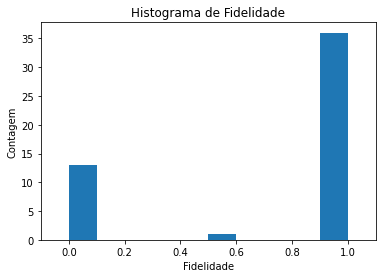

In [120]:
plt.hist(faithfulness)

plt.xlim(-0.1, 1.1)

plt.title("Histograma de Fidelidade")
plt.xlabel("Fidelidade")
plt.ylabel("Contagem")

plt.show()

Enquanto que a relevância da resposta se concentra em pontuações baixas:

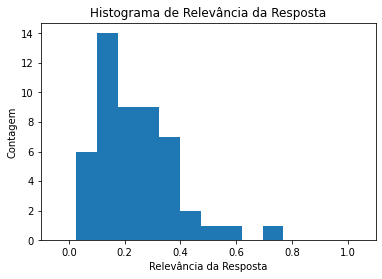

In [118]:
plt.hist(answer_relevance)

plt.xlim(-0.1, 1.1)

plt.title("Histograma de Relevância da Resposta")
plt.xlabel("Relevância da Resposta")
plt.ylabel("Contagem")

plt.show()

E a relevância do contexto tem um pico na pontuação máxima, devido ao problema de intervalo já discutido:

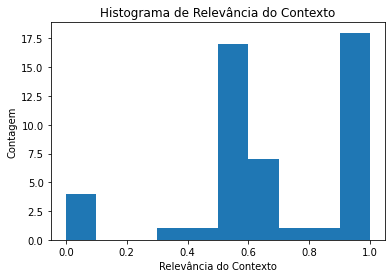

In [119]:
plt.hist(context_relevance)

plt.title("Histograma de Relevância do Contexto")
plt.xlabel("Relevância do Contexto")
plt.ylabel("Contagem")

plt.show()

Observando a correlação entre as métricas, mais precisamente a raiz dela, podemos perceber que as métricas são moderadamente relacionadas, principalmente a fidelidade e relevância do contexto (possivelmente um contexto mais relevante também seja mais útil para obter a resposta, tornando-a mais fiel), o que indica uma possível dificuldade em avaliar separadamente estes três aspectos (as métricas não avaliam aspectos "ortogonais"), exceto entre os aspectos de relevância de resposta e contexto. Todas as correlações são positivas, indicando que aumentam junto com a melhoria do processo e resposta:

In [185]:
faithfulness_norm = faithfulness/faithfulness.std(ddof=1)
answer_relevance_norm = answer_relevance/answer_relevance.std(ddof=1)
context_relevance_norm = context_relevance/context_relevance.std(ddof=1)

In [189]:
cov = np.cov([faithfulness_norm, answer_relevance_norm, context_relevance_norm])

cov

array([[1.        , 0.15436366, 0.19841588],
       [0.15436366, 1.        , 0.02803894],
       [0.19841588, 0.02803894, 1.        ]])

In [188]:
np.sqrt(cov)

array([[1.        , 0.3928914 , 0.44543897],
       [0.3928914 , 1.        , 0.16744832],
       [0.44543897, 0.16744832, 1.        ]])